In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time 

from qcodes import Instrument
from qcodes import new_experiment
from qcodes.dataset.plotting import plot_by_id
from qcodes.instrument.parameter import ManualParameter
from qcodes.sweep import nest, sweep, getter, setter, run, time_trace

In [3]:
class SomeInstrument(Instrument): 
    def __init__(self, name, time_constant): 
        super().__init__(name)
        
        self._time_constant = time_constant
        self._target_value = 0
        
        self._initial_value = 0
        self._initial_value_set_time = time.time()

        self.add_parameter(
            "x", 
            set_cmd=self._set_value, 
            get_cmd=self._get_value
        )
        
        self.add_parameter(
            "ts", 
            set_cmd=self._set_timeconstant, 
            get_cmd=self._get_timeconstant
        )
        
    def _reset(self): 
        self._initial_value_set_time = time.time()
        self._initial_value = self._get_value()
        
    def _get_value(self): 
        dt = time.time() - self._initial_value_set_time
        f = np.exp(-dt/self._time_constant)
        return self._initial_value * f + self._target_value * (1 - f)
    
    def _set_value(self, value): 
        self._reset()
        self._target_value = value
        
    def _set_timeconstant(self, time_constant): 
        self._time_constant = time_constant
    
    def _get_timeconstant(self): 
        return self._time_constant

In [4]:
instrument = SomeInstrument("instrument", 0.5)

In [5]:
def setup(value):
    instrument.x(value)

def cleanup():
    instrument.x(0)
    
so = time_trace(instrument.x, 0.01, 1.5)

data = run(
    [(setup, (2.,))],
    so,
    [(cleanup, ())]
)

Starting experimental run with id: 47


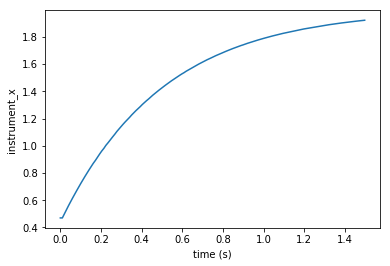

In [6]:
data.plot()

In [10]:
def start(value):
    instrument.x(value)

def stop():
    instrument.x(0)
    
so = nest(
    sweep(instrument.ts, np.linspace(0.5, 1.0, 3)),
    time_trace(instrument.x, 0.01, 1.5).on_sweep_start([(start, (2.0,))]).on_sweep_end([(stop, ())])
)

data = run(
    [(lambda: None, ())],
    so,
    [(lambda: None, ())]
)

Starting experimental run with id: 49


2D data does not seem to be on a grid. Falling back to scatter plot


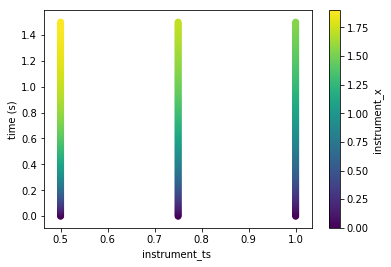

In [11]:
data.plot(labels=instrument.ts)

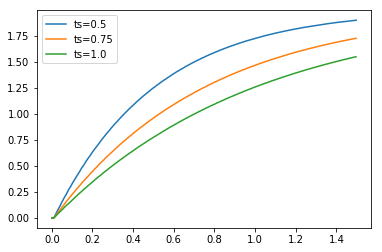

In [25]:
tsvals = np.unique(data["instrument_ts"]["instrument_ts"])

fig, ax = plt.subplots()

for tsval in tsvals:
    idx = data["instrument_ts"]["instrument_ts"] == tsval
    t = data["instrument_ts"]["time"][idx]
    x = data["instrument_ts"]["instrument_x"][idx]
    ax.plot(t, x, label=f"ts={tsval}")

plt.legend()

In [16]:
@setter([("run_nr", "V")])
def x_reset(run_nr): 
    instrument.x(0)
    while instrument.x() > 0.05:
        pass
    
    instrument.x(2.0)

so = nest(
    sweep(x_reset, range(4)), 
    time_trace(instrument.x, 0.01, 1.5)
)

def setup():
    pass

def cleanup():
    instrument.x(0)
    
data = run(
    [(setup, ())],
    so,
    [(cleanup, ())]
)

Starting experimental run with id: 44


In [18]:
d = data["instrument_x"]

In [20]:
runs = np.unique(d["run_nr"])
print(runs)

[0 1 2 3]


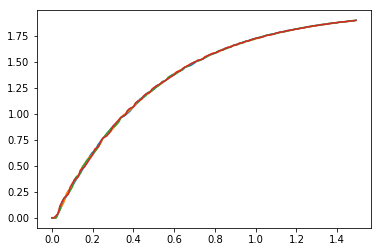

In [22]:
for run in runs: 
    idx = np.nonzero(d["run_nr"] == run)
    x = d["time"][idx]
    y = d["instrument_x"][idx]
    p = plt.plot(x, y)
    plt.legend()

In [30]:
import re

In [31]:
s = "sohail is cool"

In [32]:
re.match("sohail", s)

<_sre.SRE_Match object; span=(0, 6), match='sohail'>

In [33]:
re.compile("sohail").sub("Shirin", s)

'Shirin is cool'